In [86]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib configuration

In [100]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 200

---
Mass of star $M$ ($M_\odot$)

In [51]:
M = 20

---
### Simulation data for $^{23}$Na

In [42]:
model_id = 1866

In [52]:
simulation = pd.read_csv(f"{M}M_models/model_{model_id}.csv")
simulation

,radius,log_mass_fraction,log_T_core,radius_temp,log_Ts,radius_rho,log_rhos,log_star_age
0,0.006362,-1.909480,9.228972,-0.000036,10.197921,-0.000089,9.952260,6.989264
1,0.006527,-1.748408,NaN,0.000326,10.185615,0.000268,9.757676,NaN
2,0.006791,-1.632140,NaN,0.000452,10.131877,0.000459,9.434842,NaN
3,0.007201,-1.591433,NaN,0.000822,10.111762,0.000674,9.177563,NaN
4,0.007612,-1.584377,NaN,0.000875,10.057286,0.000576,9.638708,NaN
...,...,...,...,...,...,...,...,...
78,NaN,NaN,NaN,0.029532,8.782180,0.028688,3.789651,NaN
79,NaN,NaN,NaN,0.029927,8.765341,0.029105,3.780926,NaN
80,NaN,NaN,NaN,0.030195,8.770152,0.029516,3.818316,NaN
81,NaN,NaN,NaN,NaN,NaN,0.029960,3.756733,NaN


Range of radii ($R_\odot$)

In [63]:
r = simulation["radius"]

Temperatures at radii (K)

In [71]:
T = 10 ** simulation["log_Ts"]

Mass of $^{23}$Na ($M_\odot$)

In [72]:
M_Na = M * (10 ** simulation["log_mass_fraction"])

---
### Plotting parameters

Stellar metallicity $Z$ ($Z_\odot$)

In [135]:
Z_range = np.linspace(0.2, 1, 5)

Flavor-singet axial-vector matrix element $S$

In [143]:
S_range = np.linspace(-1, 2, 5)

Axion mass $m_a$ (eV)

In [28]:
m_a_range = np.linspace(0, 1, 30)

---
Boltzmann constant $k_B$ (keV/K)

In [49]:
k = 8.617e-8

Axion luminosity for $^{23}$Na (kW)

$\displaystyle L 
= \cfrac{Z}{Z_\odot}
\times \left[\frac{m_a}{\text{eV}}\right]^2
\times 7.2\cdot10^8\frac{\text{erg}}{\text{g}\cdot\text{s}}
\times [1 + 1.07S]^2
\times \sum_r \frac{M_{23\text{Na}}(r)}{1.5 + \exp\left(\cfrac{440\text{ keV}}{k\cdot T(r)}\right)}
\times 10^{-10}\text{ kW/erg}$

In [156]:
L_Na = lambda Z, S, m_a: Z * (m_a**2) * 7.2e8 * ((1 + 1.07*S)**2) * np.sum(M_Na / (1.5 + np.exp( 440 / (k * T) ))) * 1e-10

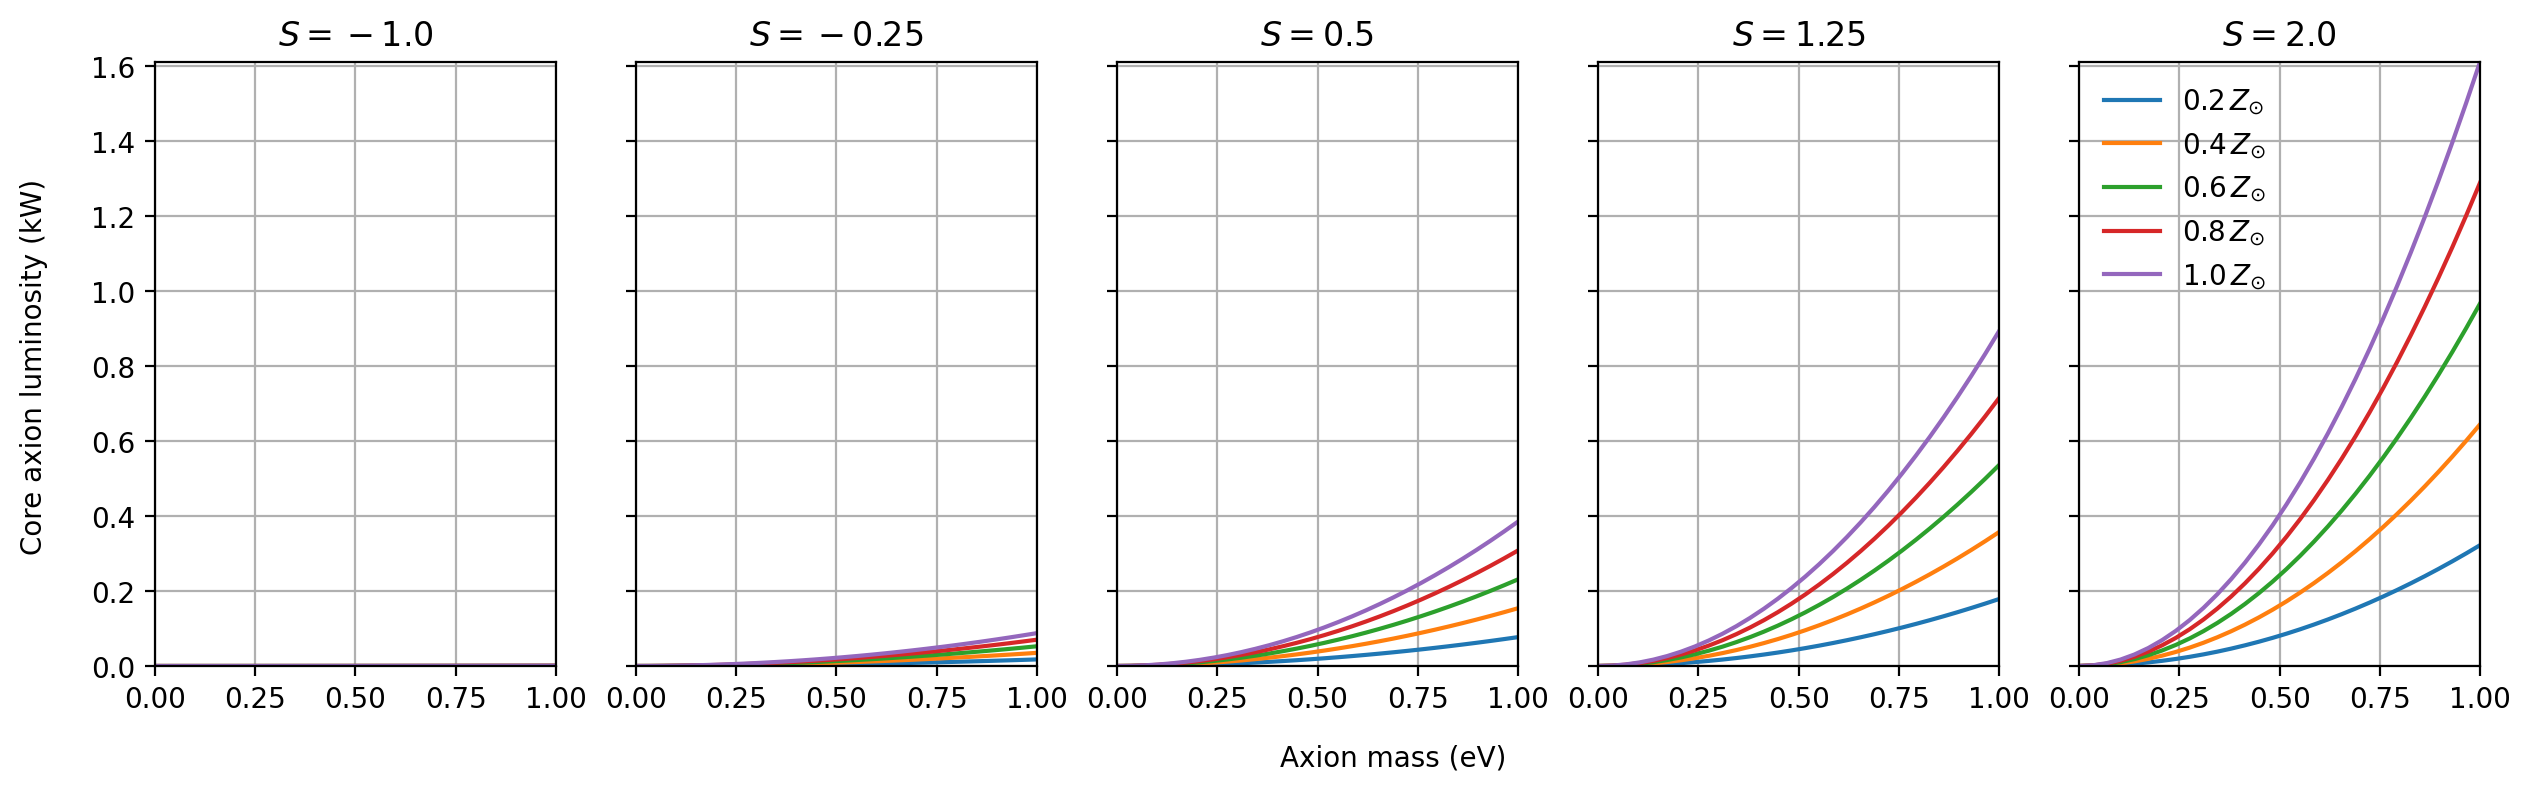

In [155]:
fig, axs = plt.subplots(1, len(S_range), sharex=True, sharey=True, figsize=(3*len(S_range), 4))
for (i, S) in enumerate(S_range):
    for Z in Z_range:
        plt.sca(axs[i])
        plt.plot(m_a, L_Na(Z, S, m_a), label=f"${Z:.1f}\, Z\!_\odot$")
        plt.title(f"$S = {S}$")
        plt.grid()
        plt.margins(0)
plt.legend(frameon=False)
fig.text(0.08, 0.5, "Core axion luminosity (kW)", va='center', rotation='vertical')
fig.text(0.5, 0.01, "Axion mass (eV)", va='center', rotation='horizontal')
plt.show()